# Figure 6

In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import sys
import os
from itertools import product
from tqdm import tqdm
import multiprocessing as mp
import re
import pickle
import cv2
import imageio
import shutil
# enables the %%R magic
import rpy2.ipython
%load_ext rpy2.ipython

sys.path.append('./utils/')
from odeAnalysisUtils import GenerateATComparisonPlot
from myUtils import mkdir
from fittingUtils import PatientToOutcomeMap, LoadPatientData, LoadFit, GetBestFit, SimulateFit, \
            PlotFit, PlotFits, \
            GenerateFitSummaryDf_AllPatients, visualize_scatter_with_images

# Format plots
sns.set(style="white",
        font_scale=1.5,
        rc={'figure.figsize':(12,6)})

In [2]:
dataDir = "./data/clinicalData/Bruchovsky_et_al/"
fitDir = "./data/fits/"
patientList_all = [int(re.findall(r'\d+',x)[0]) for x in os.listdir(dataDir)]
nFits = 10
solver_kws = {'nReplicates':250}
initialSeedingType = "random"
patientsToExcludeDic = {"fits_all": [32, 46, 64, 83, 92] + [2,3,6,11,50,52,84,95,101,104,105], # patients with mets + patients with poor fits
                        "fits_costTurnover": [32, 46, 64, 83, 92] + [2,3,6,11,13,50,52,84,95,101,104]}
# Make directory for figures
if not os.path.isdir("./figures/"):
    os.mkdir("./figures/")

Note: to perform fitting run `run_dataFitting_all.py`, `run_dataFitting_costTurnover.py`, and `run_dataFitting_n0fR.py`. Each takes a couple of hours. To allow reproducing the plots in the paper, I have uploaded the final inferred parameters in each case to the github repository. These can be found in the `fitSummaryDf_curated.csv` files inside the three directories in `./data/fits/`.

## Quality check the fits

### Plot the nFits different fits for each patient

#### Fast version (using already existing pngs from the fitting)

In [41]:
modelName = "fits_costTurnover" # "fits_all"
for patientId in [41]:#patientList_all:
    currFitDir = os.path.join(fitDir,modelName)
    mkdir(os.path.join(currFitDir,"overview"))
    fig, axList = plt.subplots(2, 5, sharex=True, sharey=True, figsize=(40, 10))
    bestFit = GetBestFit(patientId=patientId,fitDir=currFitDir)
    for i,fitId in enumerate(range(nFits)):
        # Load image
        fit = LoadFit(fitId=fitId,patientId=patientId,fitDir=currFitDir)
        currImgDir = os.path.join(currFitDir,"patient%d"%patientId,"patient_%d_fit_%d.png"%(patientId,fitId))
        currImg = cv2.imread(currImgDir)
        currImg = cv2.cvtColor(currImg, cv2.COLOR_RGB2BGR)

        currAx = axList.flatten()[i]
        currAx.imshow(currImg)
#         currAx.axis('off')
        currAx.set_title("F%d;R2=%1.2f" % (fitId, fit.rSq))
        if fitId==bestFit.fitId: 
            currAx.spines['bottom'].set_color('red')
            currAx.spines['top'].set_color('red') 
            currAx.spines['right'].set_color('red')
            currAx.spines['left'].set_color('red')
    plt.tight_layout()
    plt.savefig(os.path.join(currFitDir,"overview/patient%d.png"%patientId))
    plt.close()

#### Slow version (simulating from scratch; takes about 10h)

In [5]:
def PlotAllFits(job):
    patientId = job
    solver_kws['initialSeedingType'] = initialSeedingType
    currFitDir = os.path.join(fitDir,modelName)
    utils.mkdir(os.path.join(currFitDir,"overview"))
    bestFit = GetBestFit(patientId=patientId,fitDir=currFitDir)
    fig, axList = plt.subplots(2, 5, sharex=True, sharey=True, figsize=(15, 7))
    for i,fitId in enumerate(range(nFits)):
        fit = LoadFit(fitId=fitId,patientId=patientId,fitDir=currFitDir)
        PlotFits(fits=[fit.fitId], dataDf=LoadPatientData(patientId,dataDir=dataDir), fitDir=currFitDir,
                 solver_kws=solver_kws,
                 ylim=2.5, titleStr="F%d;R2=%1.2f" % (fitId, fit.rSq), ax=axList.flatten()[i])
        if fitId==bestFit.fitId: axList.flatten()[i].patch.set_facecolor(sns.xkcd_rgb["light grey"])
    plt.savefig(os.path.join(currFitDir,"overview/patient%d.png"%patientId))
    plt.close()

modelName = "fits_all" # "fits_costTurnover"
[PlotAllFits(job) for job in patientList_all]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

### Generate curated patientSummaryDfs 

Exclude patients with poor fits defined in `patientsToExcludeList`

In [25]:
for modelName in ["fits_all", "fits_costTurnover"]:
    currFitDir = os.path.join(fitDir,modelName)
    fitSummaryDf = pd.read_csv(os.path.join(currFitDir,"fitSummaryDf.csv"),index_col=0)
    fitSummaryDf = fitSummaryDf[np.isin(fitSummaryDf.PatientId,patientsToExcludeDic[modelName])==False]
    fitSummaryDf.to_csv(os.path.join(currFitDir,"fitSummaryDf_curated.csv"))

## a) & b) Example fits of slow and fast cycler

In [6]:
modelName = "fits_all"
currFitDir = os.path.join(fitDir,modelName)
fitSummaryDf = pd.read_csv(os.path.join(currFitDir,"fitSummaryDf_curated.csv"),index_col=0)
fitSummaryDf['CyclingFreq'] = fitSummaryDf.NCycles/fitSummaryDf.TimeInTrial

In [7]:
patientsToPlotList = [75,88] #[36,41] [55,31] #[42,96,55]
seedToShowImagesFor = 0

### a) Time-series plots

No handles with labels found to put in legend.


P75;R2=0.31


No handles with labels found to put in legend.


P88;R2=0.90


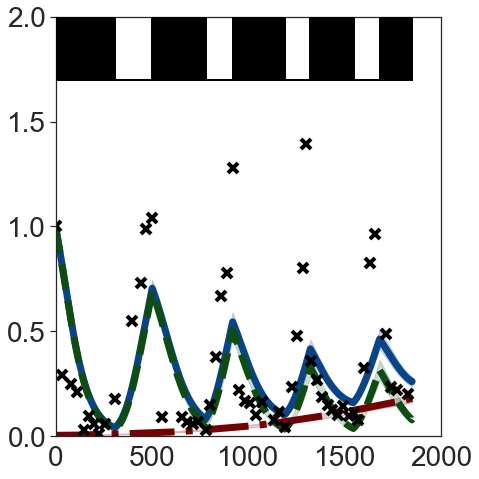

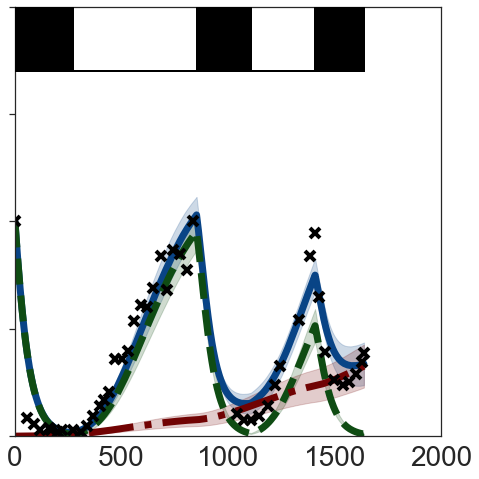

In [8]:
solver_kws['initialSeedingType'] = initialSeedingType
solver_kws['nReplicates'] = 250
currFitDir = os.path.join(fitDir,modelName)
fitSummaryDf = pd.read_csv(os.path.join(currFitDir,"fitSummaryDf_curated.csv"),index_col=0)
for patientId in patientsToPlotList:
    fit = GetBestFit(patientId=patientId,summaryDf=fitSummaryDf,fitDir=currFitDir)
    PlotFits([fit],dataDf=LoadPatientData(patientId,dataDir=dataDir),
             solver_kws=solver_kws, decorateY=patientId==75,
             xlim=2e3,ylim=2.,figsize=(7,7),axisLabels=False,
             outName="./figures/exampleFit_p%d.pdf"%(patientId))
    print("P%d;R2=%1.2f"%(patientId,fit.rSq))  

### b) Images

#### Check that chosen seeds are representative of the mean behaviour

2it [04:56, 148.09s/it]


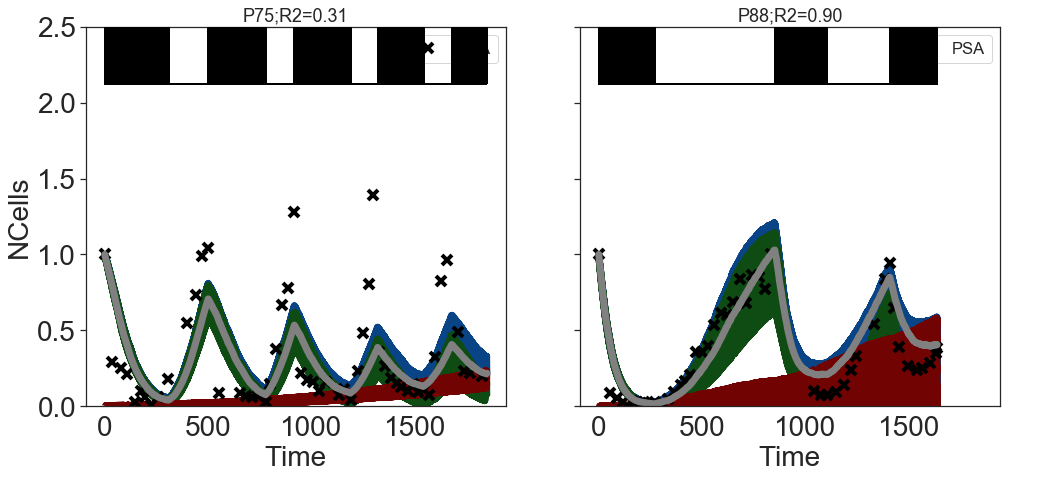

In [16]:
currFitDir = os.path.join(fitDir,modelName)

fig, axList = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(15, 7))
for i,patientId in tqdm(enumerate(patientsToPlotList)):
    fit = GetBestFit(patientId=patientId,summaryDf=fitSummaryDf,fitDir=currFitDir)
    PlotFits(fits=[fit.fitId], dataDf=LoadPatientData(patientId,dataDir=dataDir), fitDir=currFitDir,aggregateData=False,
             solver_kws=solver_kws,
             ylim=2.5, titleStr="P%d;R2=%1.2f" % (patientId, fit.rSq), ax=axList.flatten()[i])
    currDfName = os.path.join(currFitDir,"patient%d"%patientId,"images/data/results_RepId_%d.csv"%seedToShowImagesFor)
    tmpDf = pd.read_csv(currDfName)
    tmpDf['NCells'] /= tmpDf['NCells'].iloc[0]
    sns.lineplot(x="Time",y="NCells",lw=7,color="grey",data=tmpDf,ax=axList.flatten()[i])

#### Collect images

In [27]:
currFitDir = os.path.join(fitDir,modelName)
fitSummaryDf = pd.read_csv(os.path.join(currFitDir,"fitSummaryDf_curated.csv"),index_col=0)
imageRecording_kws = {**solver_kws, "profilingMode":"false","terminateAtProgression":"true",
                      "imageFreq":10}
imageRecording_kws['nReplicates'] = 1
for patientId in tqdm(patientsToPlotList):
    outDir = os.path.join(currFitDir,"patient%d"%patientId,"images/data/")
    imgDir = os.path.join(currFitDir,"patient%d"%patientId,"images/images/")
    imageRecording_kws['initialSeedingType'] = initialSeedingType
    imageRecording_kws['seed'] = seedToShowImagesFor
    imageRecording_kws["imageOutDir"] = imgDir
    imageRecording_kws["outDir"] = outDir  
    fit = GetBestFit(patientId=patientId,summaryDf=fitSummaryDf,fitDir=currFitDir)
    SimulateFit(fit, dataDf=LoadPatientData(patientId,dataDir=dataDir), trim=False, saveFiles=True, 
                solver_kws=imageRecording_kws)

100%|██████████| 2/2 [00:08<00:00,  4.34s/it]


#### Plot images

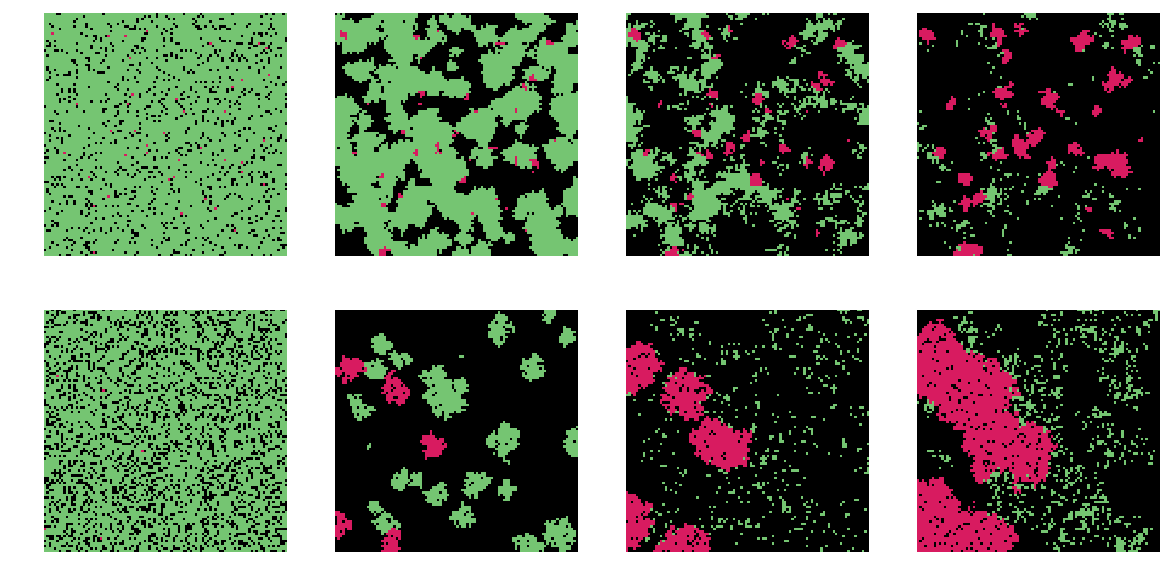

In [18]:
timePointList = [0,500,1000,1500]

fig,axList = plt.subplots(2,len(timePointList),figsize=(len(timePointList)*5,10))
for i,timePoint in enumerate(timePointList):
    for j,patientId in enumerate(patientsToPlotList):
        # Load image
        currImgDir = os.path.join(currFitDir,"patient%d"%patientId,"images/images/results_RepId_%d"%seedToShowImagesFor)
        currImg = cv2.imread(os.path.join(currImgDir,"img_t_%.1f.png"%(float(timePoint))))
        currImg = cv2.cvtColor(currImg, cv2.COLOR_RGB2BGR)

        currAx = axList[j,i]
        currAx.imshow(currImg)
        currAx.axis('off')
plt.savefig("figures/exampleSim_images.pdf")

In [20]:
# # Clean up dirs if want to save memory
# for patientId in tqdm(patientList_all):
#     for fitId in range(10):
# #         print(os.path.join(mainDir,"patient%d/fitId%d"%(patientId,fitId)))
#         try:
#             shutil.rmtree(os.path.join(currFitDir,"patient%d/images"%(patientId)))
#         except:
#             pass

### GIFs

In [28]:
modelName = "fits_all"
currFitDir = os.path.join(fitDir,modelName)
for i, patientId in enumerate(patientsToPlotList):
    # Make an inventory of the images that are available
    currImgDir = os.path.join(currFitDir,"patient%d"%patientId,"images/images/results_RepId_%d"%seedToShowImagesFor)
    fNameList = [int(float(x.split("_")[-1].split(".png")[0])) for x in os.listdir(currImgDir) if x.split(".")[-1]=="png"]
    fNameList.sort()
    images = []
    for tId in fNameList[::2]:
        currImg = cv2.imread(os.path.join(currImgDir,"img_t_%.1f.png"%(float(tId))))
        currImg = cv2.cvtColor(currImg, cv2.COLOR_RGB2BGR)
        currImg = cv2.putText(currImg, 't = %dd'%tId, (10,190), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
        # Add a square to indicate that drug is on
        currDfName = os.path.join(currFitDir,"patient%d"%patientId,"images/data/results_RepId_%d.csv"%seedToShowImagesFor)
        tmpDf = pd.read_csv(currDfName)
        if tmpDf[tmpDf.Time==tId].DrugConcentration.iloc[0]>0:
            cv2.rectangle(currImg, (175, 25), (197, 3), (255,255,255), -1)
        images.append(currImg)
    imageio.mimsave(os.path.join("gifs","patient_%d.gif"%(patientId)), images, duration=.1)

## Parameter analysis (not shown)

In [20]:
modelName = "fits_all"
currFitDir = os.path.join(fitDir,modelName)
dataToAnalyse = pd.read_csv(os.path.join(currFitDir,"fitSummaryDf_curated.csv"),index_col=0)
paramList = ["initialSize","rFrac","cost","turnover"]

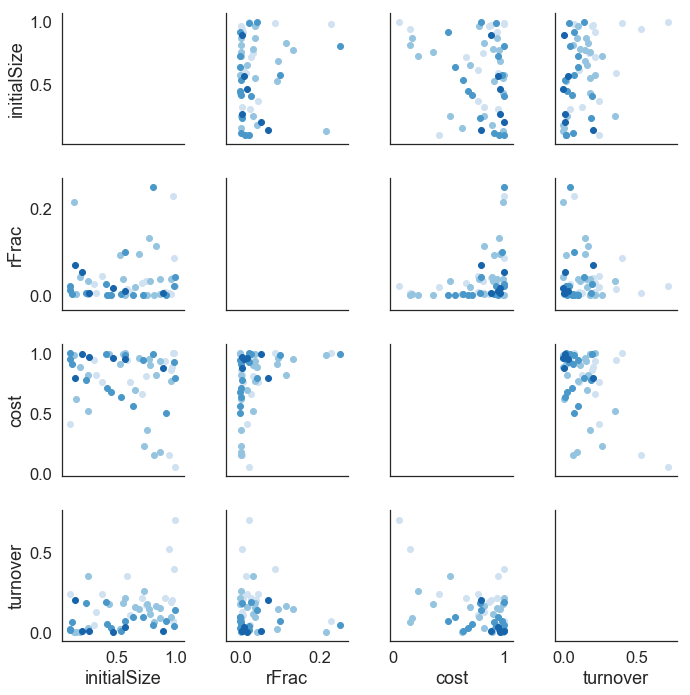

In [21]:
g = sns.PairGrid(dataToAnalyse,vars=paramList,hue='NCycles',palette="Blues")
# g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)

In [22]:
# Pearson correlation test in text
from scipy.stats import pearsonr
pearsonr(x=dataToAnalyse["turnover"],y=dataToAnalyse['cost'])

(-0.4464381237990093, 0.0005630200062443833)

In [23]:
# Comparison of parameter values between progressors and non-progressors
# paramList = ["cost","turnover"]#,"initialSize","rFrac"]
for param in paramList:
    print(param,scipy.stats.mannwhitneyu(dataToAnalyse.loc[dataToAnalyse.Progression==0,param],
                    dataToAnalyse.loc[dataToAnalyse.Progression==1,param]))

initialSize MannwhitneyuResult(statistic=194.0, pvalue=0.3522490560525655)
rFrac MannwhitneyuResult(statistic=177.0, pvalue=0.22407254156484713)
cost MannwhitneyuResult(statistic=56.0, pvalue=0.0002721833670841176)
turnover MannwhitneyuResult(statistic=209.0, pvalue=0.48220577844129603)


In [24]:
dataToAnalyse['CyclingFreq'] = dataToAnalyse.TimeInTrial/dataToAnalyse.NCycles

(0.6202282670518326, 3.4292559448367007e-07)

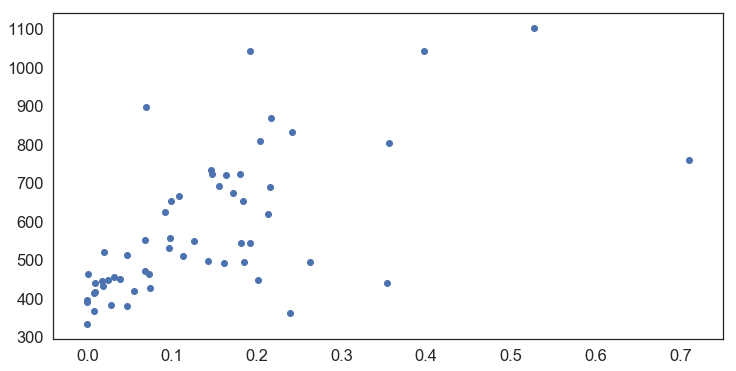

In [25]:
plt.scatter(dataToAnalyse["turnover"],dataToAnalyse['CyclingFreq'])
pearsonr(x=dataToAnalyse["turnover"],y=dataToAnalyse['CyclingFreq'])

(-0.047180901081715285, 0.7298698537245784)

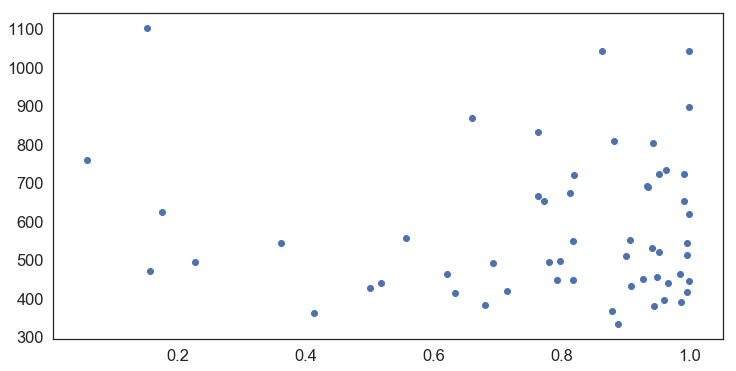

In [26]:
plt.scatter(dataToAnalyse["cost"],dataToAnalyse['CyclingFreq'])
pearsonr(x=dataToAnalyse["cost"],y=dataToAnalyse['CyclingFreq'])

## c) Cost-Turnover Landscape

In [10]:
model = 'fits_costTurnover'
currFitDir = os.path.join(fitDir,model)
fitSummaryDf = pd.read_csv(os.path.join(currFitDir,"fitSummaryDf_curated.csv"),index_col=0)
fitSummaryDf['CyclingFreq'] = fitSummaryDf.NCycles/fitSummaryDf.TimeInTrial*365

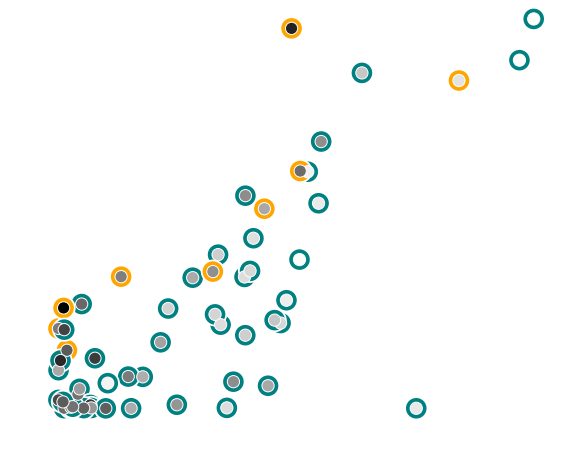

In [11]:
fig,ax = plt.subplots(1,1,figsize=(10,8))
# fitSummaryDf = fitSummaryDf[np.isin(fitSummaryDf.PatientId,[36,16,41])] #[75,88], [36,16,41]
sns.scatterplot(x="turnover",y="cost",hue="Progression",s=500, #style="Progression",
                palette={0:"teal",1:"orange"},data=fitSummaryDf,ax=ax)
sns.scatterplot(x="turnover",y="cost",hue="CyclingFreq",s=150, #style="Progression",
                palette='Greys',data=fitSummaryDf,ax=ax)

ax.set_xlim(-0.05,0.5)
ax.set_ylim(0.4,1.05)
ax.set_xlabel("")
ax.set_ylabel("")
ax.axis('off')
ax.legend().remove()
ax.invert_yaxis()
plt.savefig("./figures/paramSpacePlot_%s_all.pdf"%model)

In [12]:
fitSummaryDf['CyclingFreq'].describe()

count    56.000000
mean      0.682872
std       0.186099
min       0.330766
25%       0.528764
50%       0.691677
75%       0.819145
max       1.093906
Name: CyclingFreq, dtype: float64

In [13]:
# Pearson correlation test in text
scipy.stats.pearsonr(x=fitSummaryDf["turnover"],y=fitSummaryDf['cost'])

(-0.7578233390117193, 1.3629849631019712e-11)

In [14]:
fitSummaryDf['CyclingFreq'] = fitSummaryDf.TimeInTrial/fitSummaryDf.NCycles

(0.7363296660535003, 9.978306673596232e-11)

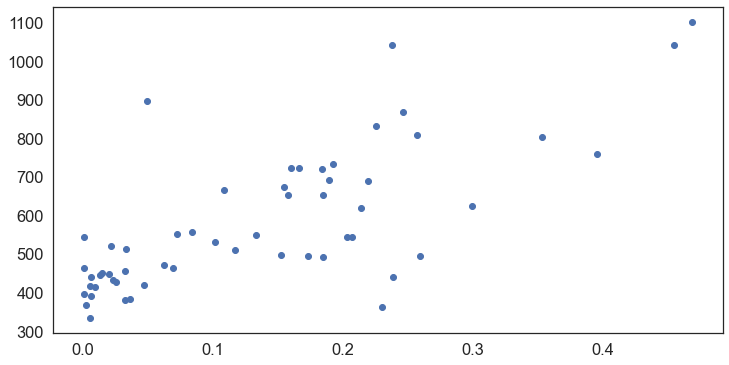

In [15]:
plt.scatter(fitSummaryDf["turnover"],fitSummaryDf['CyclingFreq'])
scipy.stats.pearsonr(x=fitSummaryDf["turnover"],y=fitSummaryDf['CyclingFreq'])

(-0.4344831821485136, 0.000820145552986887)

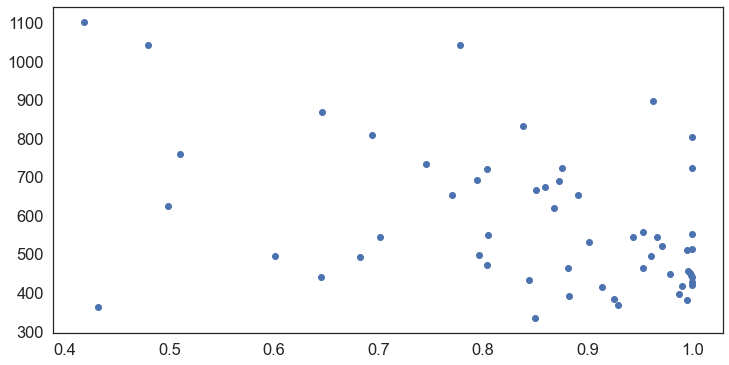

In [16]:
plt.scatter(fitSummaryDf["cost"],fitSummaryDf['CyclingFreq'])
scipy.stats.pearsonr(x=fitSummaryDf["cost"],y=fitSummaryDf['CyclingFreq'])

## d) Example simulations from the landscape

In [17]:
patientsToPlotList = [36,16,41]
seedToShowImagesFor = 1
modelName = "fits_costTurnover"

### Time-series plots

P36;R2=0.57
P16;R2=0.79
P41;R2=0.94


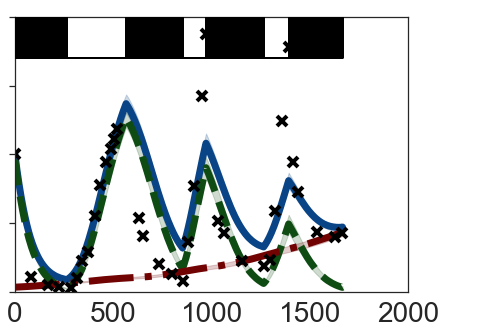

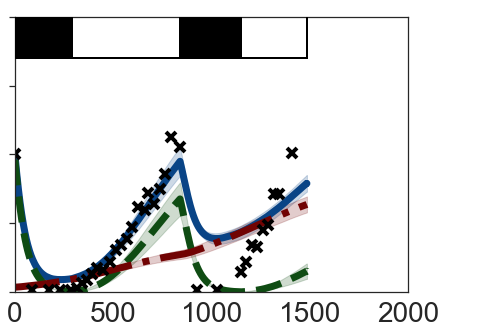

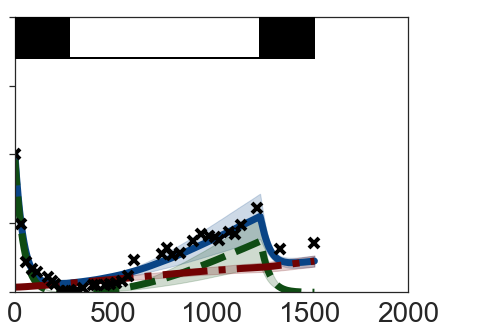

In [7]:
solver_kws['initialSeedingType'] = initialSeedingType
solver_kws['nReplicates'] = 250
currFitDir = os.path.join(fitDir,modelName)
fitSummaryDf = pd.read_csv(os.path.join(currFitDir,"fitSummaryDf_curated.csv"),index_col=0)
for patientId in patientsToPlotList:
    fit = GetBestFit(patientId=patientId,summaryDf=fitSummaryDf,fitDir=currFitDir)
    PlotFits([fit],dataDf=LoadPatientData(patientId,dataDir=dataDir),
             solver_kws=solver_kws, decorateY=False,#patientId==36,
             xlim=2e3,ylim=2.,figsize=(7,5),axisLabels=False,
             outName="./figures/exampleFit_p%d.pdf"%(patientId))
    print("P%d;R2=%1.2f"%(patientId,fit.rSq))  

### Images

#### Collect images

In [48]:
currFitDir = os.path.join(fitDir,modelName)
fitSummaryDf = pd.read_csv(os.path.join(currFitDir,"fitSummaryDf_curated.csv"),index_col=0)
imageRecording_kws = {**solver_kws, "profilingMode":"false","terminateAtProgression":"true",
                      "imageFreq":10}
imageRecording_kws['nReplicates'] = 1
for patientId in tqdm(patientsToPlotList):
    outDir = os.path.join(currFitDir,"patient%d"%patientId,"images/data/")
    imgDir = os.path.join(currFitDir,"patient%d"%patientId,"images/images/")
    imageRecording_kws['initialSeedingType'] = initialSeedingType
    imageRecording_kws['seed'] = seedToShowImagesFor
    imageRecording_kws["imageOutDir"] = imgDir
    imageRecording_kws["outDir"] = outDir  
    fit = GetBestFit(patientId=patientId,summaryDf=fitSummaryDf,fitDir=currFitDir)
    SimulateFit(fit, dataDf=LoadPatientData(patientId,dataDir=dataDir), trim=False, saveFiles=True, 
                solver_kws=imageRecording_kws)

100%|██████████| 3/3 [00:12<00:00,  4.15s/it]


#### Check that chosen seeds are representative of the mean behaviour

3it [05:14, 104.98s/it]


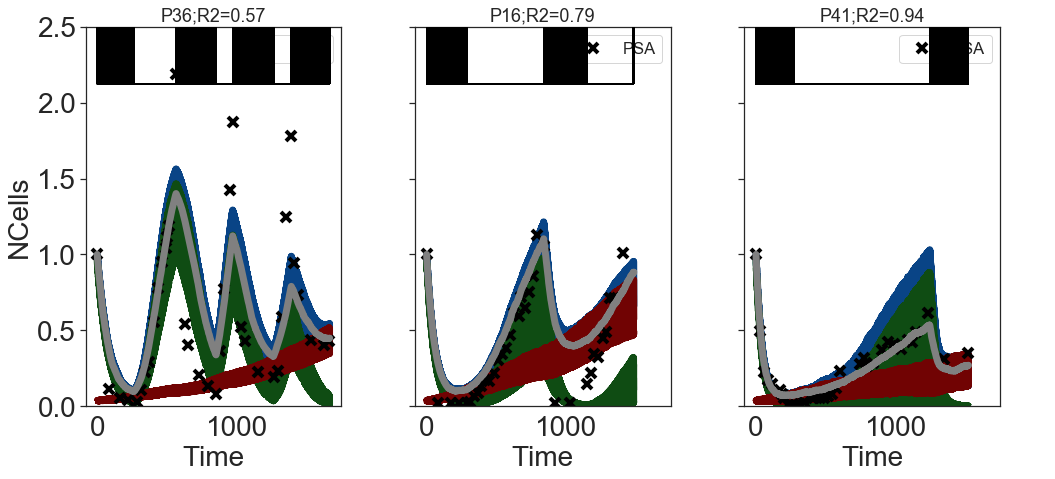

In [49]:
currFitDir = os.path.join(fitDir,modelName)

fig, axList = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(15, 7))
for i,patientId in tqdm(enumerate(patientsToPlotList)):
    fit = GetBestFit(patientId=patientId,summaryDf=fitSummaryDf,fitDir=currFitDir)
    PlotFits(fits=[fit.fitId], dataDf=LoadPatientData(patientId,dataDir=dataDir), fitDir=currFitDir,aggregateData=False,
             solver_kws=solver_kws,
             ylim=2.5, titleStr="P%d;R2=%1.2f" % (patientId, fit.rSq), ax=axList.flatten()[i])
    currDfName = os.path.join(currFitDir,"patient%d"%patientId,"images/data/results_RepId_%d.csv"%seedToShowImagesFor)
    tmpDf = pd.read_csv(currDfName)
    tmpDf['NCells'] /= tmpDf['NCells'].iloc[0]
    sns.lineplot(x="Time",y="NCells",lw=7,color="grey",data=tmpDf,ax=axList.flatten()[i])

#### Plot images

##### Middle of first cycle

260.0
280.0
270.0


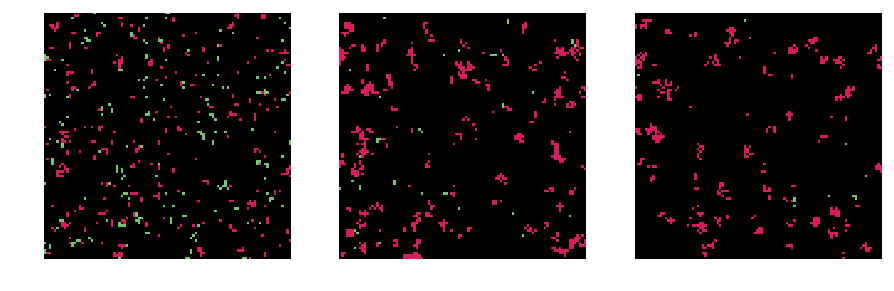

In [12]:
fig,axList = plt.subplots(1,3,figsize=(15,5))
currFitDir = os.path.join(fitDir,modelName)
for i, patientId in enumerate(patientsToPlotList):
    # Get the end point of the first cycle
    currDfName = os.path.join(currFitDir,"patient%d"%patientId,"images/data/results_RepId_%d.csv"%seedToShowImagesFor)
    tmpDf = pd.read_csv(currDfName)
    txOffTime = tmpDf.Time[tmpDf.DrugConcentration==0].values[1]
    timePoint = (txOffTime//10)*10
#     timePoint = 1450
    print(timePoint)
    # Plot the image
    currImgDir = os.path.join(currFitDir,"patient%d"%patientId,"images/images/results_RepId_%d"%seedToShowImagesFor)
    currImg = cv2.imread(os.path.join(currImgDir,"img_t_%.1f.png"%(float(timePoint))))
    currImg = cv2.cvtColor(currImg, cv2.COLOR_RGB2BGR)
    currAx = axList.flatten()[i]
    currAx.imshow(currImg)
    currAx.axis('off')
plt.savefig("./figures/exampleImages_2paramModel_onTx.pdf")

##### End of first cycle

560.0
840.0
1240.0


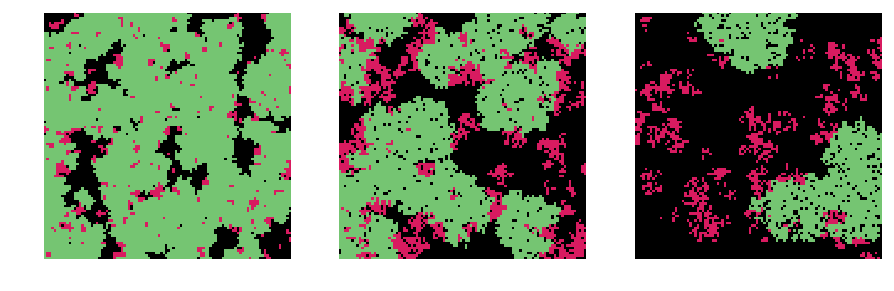

In [13]:
fig,axList = plt.subplots(1,3,figsize=(15,5))
currFitDir = os.path.join(fitDir,modelName)
for i, patientId in enumerate(patientsToPlotList):
    # Get the end point of the first cycle
    currDfName = os.path.join(currFitDir,"patient%d"%patientId,"images/data/results_RepId_%d.csv"%seedToShowImagesFor)
    tmpDf = pd.read_csv(currDfName)
    txOffTime = tmpDf.Time[tmpDf.DrugConcentration==0].values[1]
    endOfFirstCycle = tmpDf.Time[(tmpDf.Time>txOffTime) & (tmpDf.DrugConcentration==1)].min()
    timePoint = (endOfFirstCycle//10)*10
#     timePoint = 1450
    print(timePoint)
    # Plot the image
    currImgDir = os.path.join(currFitDir,"patient%d"%patientId,"images/images/results_RepId_%d"%seedToShowImagesFor)
    currImg = cv2.imread(os.path.join(currImgDir,"img_t_%.1f.png"%(float(timePoint))))
    currImg = cv2.cvtColor(currImg, cv2.COLOR_RGB2BGR)
    currAx = axList.flatten()[i]
    currAx.imshow(currImg)
    currAx.axis('off')
plt.savefig("./figures/exampleImages_2paramModel_offTx.pdf")

In [51]:
# # Clean up dirs if want to save memory
# for patientId in tqdm(patientList_all):
#     for fitId in range(10):
# #         print(os.path.join(mainDir,"patient%d/fitId%d"%(patientId,fitId)))
#         try:
#             shutil.rmtree(os.path.join(currFitDir,"patient%d/images"%(patientId)))
#         except:
#             pass

### GIFs

In [19]:
currFitDir = os.path.join(fitDir,modelName)
for i, patientId in enumerate(patientsToPlotList):
    # Make an inventory of the images that are available
    currImgDir = os.path.join(currFitDir,"patient%d"%patientId,"images/images/results_RepId_%d"%seedToShowImagesFor)
    fNameList = [int(float(x.split("_")[-1].split(".png")[0])) for x in os.listdir(currImgDir) if x.split(".")[-1]=="png"]
    fNameList.sort()
    images = []
    for tId in fNameList[::2]:
        currImg = cv2.imread(os.path.join(currImgDir,"img_t_%.1f.png"%(float(tId))))
        currImg = cv2.cvtColor(currImg, cv2.COLOR_RGB2BGR)
        currImg = cv2.putText(currImg, 't = %dd'%tId, (10,190), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
        # Add a square to indicate that drug is on
        currDfName = os.path.join(currFitDir,"patient%d"%patientId,"images/data/results_RepId_%d.csv"%seedToShowImagesFor)
        tmpDf = pd.read_csv(currDfName)
        if tmpDf[tmpDf.Time==tId].DrugConcentration.iloc[0]>0:
            cv2.rectangle(currImg, (175, 25), (197, 3), (255,255,255), -1)
        images.append(currImg)
    imageio.mimsave(os.path.join("gifs","patient_%d.gif"%(patientId)), images, duration=.1)

### Neighbourhood Analysis

#### Code for neighbourhood analysis

In [3]:
def RunNeighbourhoodAnalysis(nReplicates,modelConfigDic,patientId,fitSummaryDf,fitDir):
    tmpDicList = []
    for replicateId in tqdm(range(nReplicates),total=nReplicates):
        # Simulate treatment
        fit = GetBestFit(patientId=patientId,summaryDf=fitSummaryDf,fitDir=fitDir)
        modelConfigDic['seed'] = replicateId
        SimulateFit(fit, dataDf=LoadPatientData(patientId,dataDir=dataDir), trim=False, saveFiles=True, 
                    solver_kws=modelConfigDic)
        
        # Analyse neighbourhood structure
        # Read info for this run
        currDfName = os.path.join(modelConfigDic['outDir'],"results_RepId_%d.csv"%replicateId)
        tmpDf = pd.read_csv(currDfName)
        for timePoint in np.arange(0,tmpDf.Time.max(),imageFreq):
            # Plot the image
            currImgDir = os.path.join(modelConfigDic['outDir'],"results_RepId_%d"%replicateId)
            currImg = cv2.imread(os.path.join(currImgDir,"img_t_%.1f.png"%(float(timePoint))))
            currImg = cv2.cvtColor(currImg, cv2.COLOR_RGB2BGR)

            # Count the number of neighbours for each resistant cell
            sensitiveMask = (currImg[:,:,0] == 117)*1        
            resistantMask = (currImg[:,:,0] == 216)*1
            k = np.array([[0,1,0],[1,0,1],[0,1,0]])
            nNeighbourhoodSites = np.sum(k)
            nResistantNeighboursMat = scipy.ndimage.convolve(resistantMask, k, mode='constant', cval=0.0)
            nResistantNeighboursMat[resistantMask==0] = 0

            nSensitiveNeighboursMat = scipy.ndimage.convolve(sensitiveMask, k, mode='constant', cval=0.0)
            nSensitiveNeighboursMat[resistantMask==0] = 0

            nEmptySpaceNeighboursMat = np.ones_like(nSensitiveNeighboursMat)*nNeighbourhoodSites - nSensitiveNeighboursMat - nResistantNeighboursMat
            nEmptySpaceNeighboursMat[resistantMask==0] = 0

            # Save results
            nCells_R = np.sum(resistantMask)
            tmpDicList.append({"PatientId":patientId,"ReplicateId":replicateId,"Time":timePoint,
                               "DrugConcentration":tmpDf.DrugConcentration[tmpDf.Time==timePoint].values[0],
                               "FracSensitive":np.sum(nSensitiveNeighboursMat)/nCells_R/nNeighbourhoodSites,
                               "FracResistant":np.sum(nResistantNeighboursMat)/nCells_R/nNeighbourhoodSites,
                               "FracEmpty":np.sum(nEmptySpaceNeighboursMat)/nCells_R/nNeighbourhoodSites})
    shutil.rmtree(modelConfigDic['outDir'])
    return pd.DataFrame(tmpDicList)

In [4]:
def Convert2EvoFreq(dataDf,colList=['FracSensitive','FracResistant','FracEmpty']):
    currDataDf = dataDf.groupby('Time').mean()[colList]
    currDataDf = currDataDf.transpose()
    currDataDf.reset_index(inplace=True); currDataDf.rename(columns={'index':'Neighbour'},inplace=True)
    currDataDf.insert(1, 'CloneID', currDataDf.index+1); currDataDf.insert(2, 'ParentID', 0)
    # Add a dummy 'parent' to use for visulasation within EvoFreq
    currDataDf.loc[-1,:] = 0
    currDataDf.loc[-1,'Neighbour'] = 'Dummy'
    currDataDf['Color'] = ['#75C571','#D5115A','#000000','#000000']
    return currDataDf

#### Import EvoFreq

In [5]:
%%R
library(EvoFreq)

R[write to console]: Loading required package: ggplot2

R[write to console]: Loading required package: reshape2

R[write to console]: Loading required package: dplyr

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




#### Analyse neighbourhood

In [11]:
modelName = "fits_costTurnover"
currFitDir = os.path.join(fitDir,modelName)
fitSummaryDf = pd.read_csv(os.path.join(currFitDir,"fitSummaryDf_curated.csv"),index_col=0)
outDir = "./data/neighbourhoodAnalysis_patients/"
nReplicates = 250 # Number of total replicates to examine
imageFreq = 10
patientsToPlotList = [36,16,41]
modelConfigDic = {**solver_kws, "profilingMode":"false","terminateAtProgression":"true",
                  "imageOutDir":"./tmp/neighbourhoodAnalysis/","imageFreq":imageFreq,
                  "outDir":"./tmp/neighbourhoodAnalysis/"}
modelConfigDic['nReplicates'] = 1 # Want to analyse one simulation at a time

In [12]:
mkdir(outDir)
for patientId in patientsToPlotList:
    neighbourhoodStructureDf = RunNeighbourhoodAnalysis(nReplicates,modelConfigDic,patientId,fitSummaryDf,currFitDir)
    neighbourhoodStructureDf = neighbourhoodStructureDf[neighbourhoodStructureDf.Time<1500]
    tmpDf = Convert2EvoFreq(neighbourhoodStructureDf)
    tmpDf.to_csv(os.path.join(outDir,"neighbourhoodAnalysis_p%d.csv"%patientId),index=False)
    neighbourhoodStructureDf.to_csv(os.path.join(outDir,"neighbourhoodAnalysisDf_p%d.csv"%patientId))

100%|██████████| 250/250 [15:02<00:00,  3.61s/it]


In [14]:
%%R -i outDir
evofreq_args = list("interpolation_steps"=0,"threshold"=0.0)
for (patientId in c(36, 16, 41)) {
    hal_info = read.HAL(print(paste(c(outDir,"neighbourhoodAnalysis_p",patientId,".csv"),collapse="")), 
                        fill_name = "Color", 
                        get_evofreq_arg_list = evofreq_args)
    fp = plot_evofreq(hal_info$freq_frame, bw=1.0, show_axes=FALSE)
    ggsave(paste(c("./figures/neighbourhoodAnalysis_p",patientId,".pdf"),collapse=""),width=10,height=6)
}

[1] "./data/neighbourhoodAnalysis_patients/neighbourhoodAnalysis_p36.csv"

[1] "Getting Mutation Counts"
  |======================================================================| 100%
[1] "Getting Plot Positions"
[1] "./data/neighbourhoodAnalysis_patients/neighbourhoodAnalysis_p16.csv"

[1] "Getting Mutation Counts"
  |======================================================================| 100%
[1] "Getting Plot Positions"
[1] "./data/neighbourhoodAnalysis_patients/neighbourhoodAnalysis_p41.csv"

[1] "Getting Mutation Counts"
  |======================================================================| 100%
[1] "Getting Plot Positions"


## Comparison of progressors and non-progressors

In [18]:
model = 'fits_costTurnover'
currFitDir = os.path.join(fitDir,model)
fitSummaryDf = pd.read_csv(os.path.join(currFitDir,"fitSummaryDf_curated.csv"),index_col=0)

In [19]:
# Get sample sizes
print("Responders: "+str(len(fitSummaryDf.loc[fitSummaryDf.Progression==0])))
print("Regressors: "+str(len(fitSummaryDf.loc[fitSummaryDf.Progression==1])))

Responders: 47
Regressors: 9


In [20]:
paramList = ["cost","turnover"]
for param in paramList:
    print(param,scipy.stats.shapiro(fitSummaryDf.loc[fitSummaryDf.Progression==0,param]))
    print(param,scipy.stats.shapiro(fitSummaryDf.loc[fitSummaryDf.Progression==1,param]))
# Data are non-normal, so use Mann-Whitney for comparison

cost ShapiroResult(statistic=0.8191488981246948, pvalue=4.386215096019441e-06)
cost ShapiroResult(statistic=0.9134550094604492, pvalue=0.34081119298934937)
turnover ShapiroResult(statistic=0.8960514664649963, pvalue=0.0005401759408414364)
turnover ShapiroResult(statistic=0.9025306105613708, pvalue=0.2670334577560425)


In [21]:
# Comparison of parameter values between progressors and non-progressors
paramList = ["cost","turnover"]#,"initialSize","rFrac"]
for param in paramList:
    print(param,scipy.stats.mannwhitneyu(fitSummaryDf.loc[fitSummaryDf.Progression==0,param],
                    fitSummaryDf.loc[fitSummaryDf.Progression==1,param]))

cost MannwhitneyuResult(statistic=95.0, pvalue=0.00482869251247412)
turnover MannwhitneyuResult(statistic=210.0, pvalue=0.49110067527474893)


MannwhitneyuResult(statistic=45.0, pvalue=0.00010639859678147552)

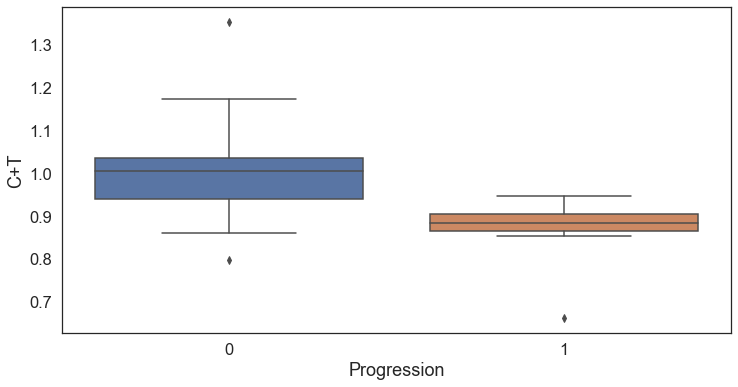

In [22]:
# Comparison of C+T score to show that combination is predictive
fitSummaryDf['C+T'] = fitSummaryDf.cost+fitSummaryDf.turnover#/(1-dataToAnalyse.turnover)

sns.boxplot(x="Progression",y="C+T",data=fitSummaryDf)
scipy.stats.mannwhitneyu(fitSummaryDf.loc[fitSummaryDf.Progression==0,"C+T"],
                fitSummaryDf.loc[fitSummaryDf.Progression==1,"C+T"])

## GIF of phase plane with fits

### Plot with images to link points to patients

In [6]:
model = 'fits_costTurnover'
currFitDir = os.path.join(fitDir,model)
fitSummaryDf = pd.read_csv(os.path.join(currFitDir,"fitSummaryDf_curated.csv"),index_col=0)
fitSummaryDf['CyclingFreq'] = fitSummaryDf.NCycles/fitSummaryDf.TimeInTrial*365

No handles with labels found to put in legend.


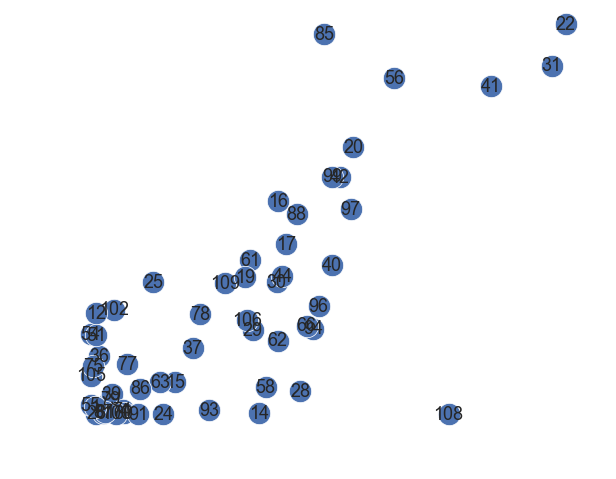

In [7]:
fig,ax = plt.subplots(1,1,figsize=(10,8))
# fitSummaryDf = fitSummaryDf[np.isin(fitSummaryDf.PatientId,[36,16,41])] #[75,88], [36,16,41]
sns.scatterplot(x="turnover",y="cost",s=500,data=fitSummaryDf,ax=ax)
# sns.scatterplot(x="turnover",y="cost",hue="PatientId",s=150,
#                 palette='Greys',data=fitSummaryDf,ax=ax)
# sns.scatterplot(x="turnover",y="cost",color='black',marker='o',s=500,
#                 data=fitSummaryDf,ax=ax)
# sns.scatterplot(x="turnover",y="cost",hue="Progression",marker='o',s=150,
#                 palette={0:"teal",1:"orange"},data=fitSummaryDf,ax=ax)
texts = [plt.text(fitSummaryDf.turnover.iloc[i], fitSummaryDf.cost.iloc[i], 
                  fitSummaryDf.PatientId.iloc[i], ha='center', va='center') for i in range(fitSummaryDf.shape[0])]
ax.set_xlim(-0.05,0.5)
ax.set_ylim(0.4,1.05)
ax.set_xlabel("")
ax.set_ylabel("")
ax.axis('off')
ax.legend().remove()
ax.invert_yaxis()
# plt.savefig("./figures/paramSpacePlot_%s_all.pdf"%model)

### Make GIFs

In [7]:
modelName = 'fits_costTurnover'
patientsToPlotList = [12,36,75,105,16,88,19,109,22,31,41]
seedToShowDic = {22:0, **dict([(x,1) for x in [12,36,75,105,16,88,19,109,31,41]])}

#### Collect images

In [8]:
currFitDir = os.path.join(fitDir,modelName)
fitSummaryDf = pd.read_csv(os.path.join(currFitDir,"fitSummaryDf_curated.csv"),index_col=0)
imageRecording_kws = {**solver_kws, "profilingMode":"false","terminateAtProgression":"true",
                      "imageFreq":10}
imageRecording_kws['nReplicates'] = 1
for patientId in tqdm(patientsToPlotList):
    outDir = os.path.join(currFitDir,"patient%d"%patientId,"images/data/")
    imgDir = os.path.join(currFitDir,"patient%d"%patientId,"images/images/")
    seedToShowImagesFor = seedToShowDic[patientId]
    imageRecording_kws['initialSeedingType'] = initialSeedingType
    imageRecording_kws['seed'] = seedToShowImagesFor
    imageRecording_kws["imageOutDir"] = imgDir
    imageRecording_kws["outDir"] = outDir  
    fit = GetBestFit(patientId=patientId,summaryDf=fitSummaryDf,fitDir=currFitDir)
    SimulateFit(fit, dataDf=LoadPatientData(patientId,dataDir=dataDir), trim=False, saveFiles=True, 
                solver_kws=imageRecording_kws)

100%|██████████| 11/11 [00:50<00:00,  4.62s/it]


#### Check that chosen seeds are representative of the mean behaviour

11it [20:39, 112.67s/it]


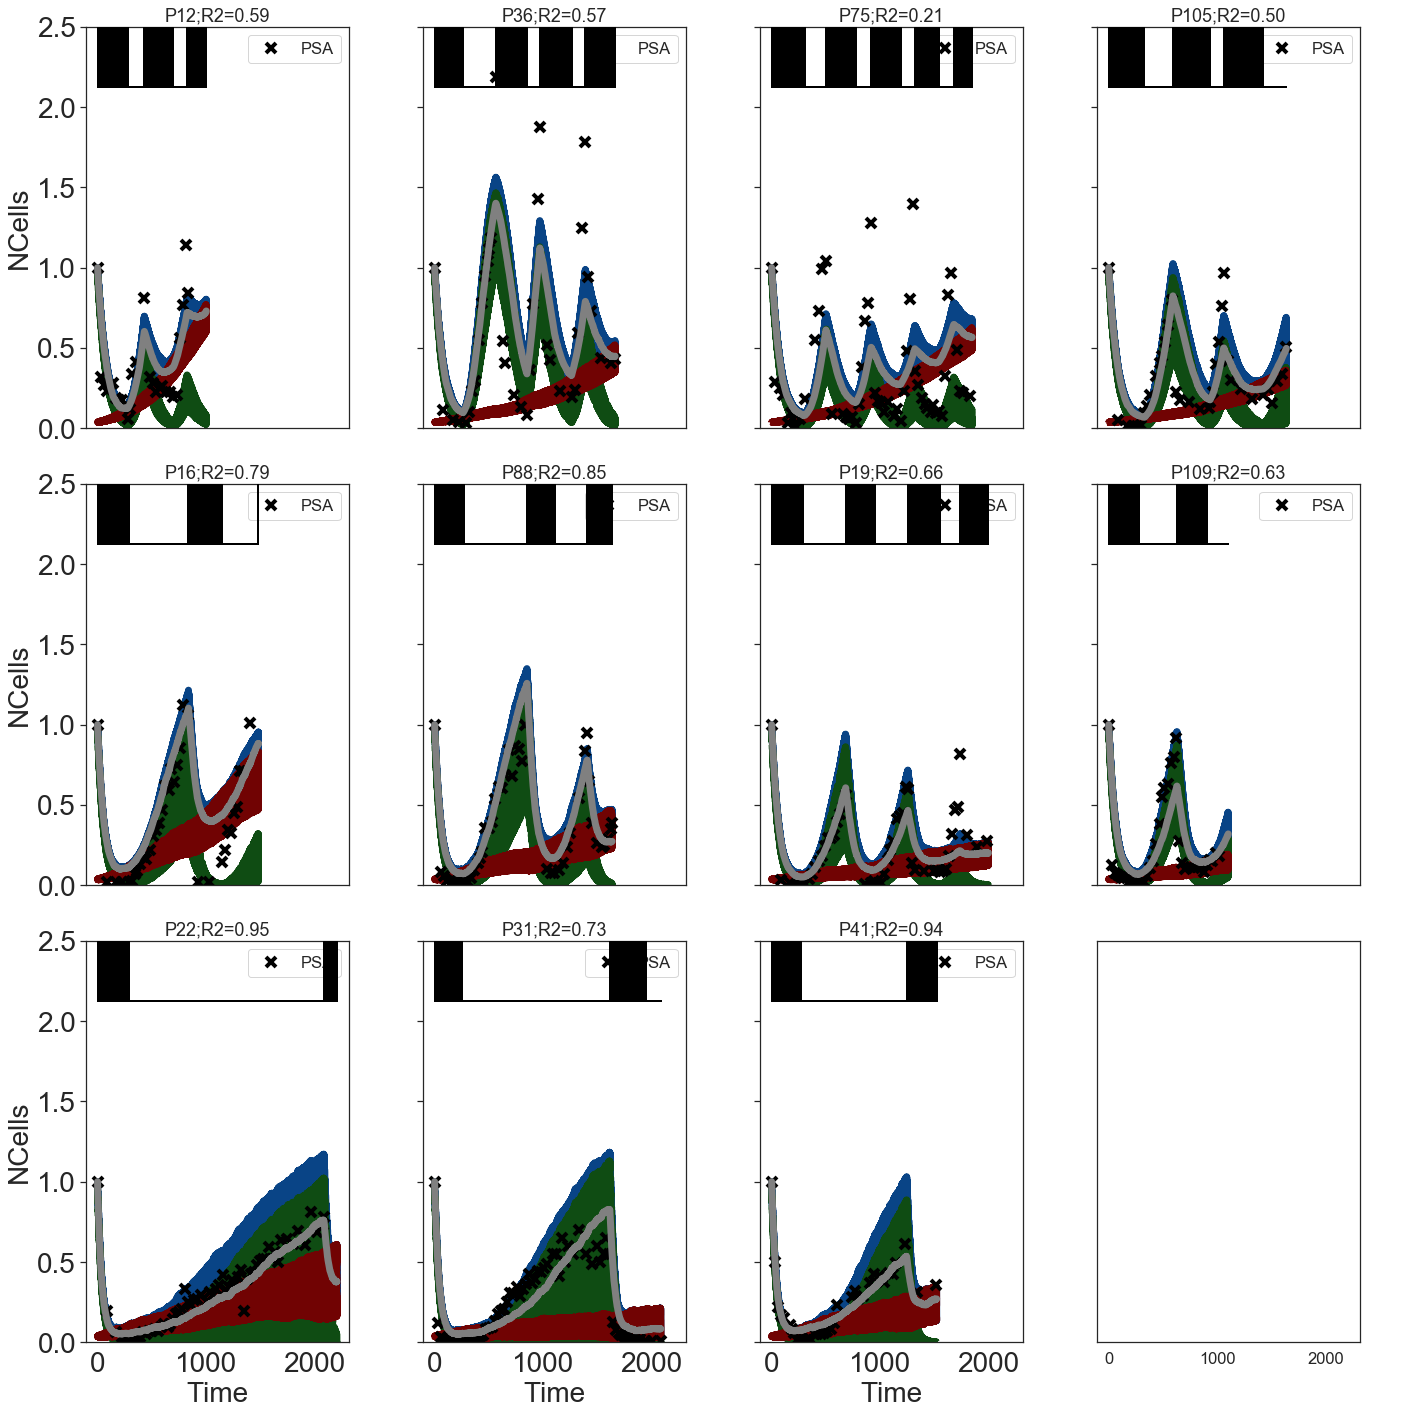

In [10]:
currFitDir = os.path.join(fitDir,modelName)
fig, axList = plt.subplots(3, 4, sharex=True, sharey=True, figsize=(20, 20))
for i,patientId in tqdm(enumerate(patientsToPlotList)):
    fit = GetBestFit(patientId=patientId,summaryDf=fitSummaryDf,fitDir=currFitDir)
    seedToShowImagesFor = seedToShowDic[patientId]
    PlotFits(fits=[fit.fitId], dataDf=LoadPatientData(patientId,dataDir=dataDir), fitDir=currFitDir,aggregateData=False,
             solver_kws=solver_kws,
             ylim=2.5, titleStr="P%d;R2=%1.2f" % (patientId, fit.rSq), ax=axList.flatten()[i])
    currDfName = os.path.join(currFitDir,"patient%d"%patientId,"images/data/results_RepId_%d.csv"%seedToShowImagesFor)
    tmpDf = pd.read_csv(currDfName)
    tmpDf['NCells'] /= tmpDf['NCells'].iloc[0]
    sns.lineplot(x="Time",y="NCells",lw=7,color="grey",data=tmpDf,ax=axList.flatten()[i])

### GIFs

In [9]:
currFitDir = os.path.join(fitDir,modelName)
for i, patientId in enumerate(patientsToPlotList):
    # Make an inventory of the images that are available
    seedToShowImagesFor = seedToShowDic[patientId]
    currImgDir = os.path.join(currFitDir,"patient%d"%patientId,"images/images/results_RepId_%d"%seedToShowImagesFor)
    fNameList = [int(float(x.split("_")[-1].split(".png")[0])) for x in os.listdir(currImgDir) if x.split(".")[-1]=="png"]
    fNameList.sort()
    images = []
    for tId in fNameList[::2]:
        currImg = cv2.imread(os.path.join(currImgDir,"img_t_%.1f.png"%(float(tId))))
        currImg = cv2.cvtColor(currImg, cv2.COLOR_RGB2BGR)
        currImg = cv2.putText(currImg, 't = %dd'%tId, (10,190), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
        # Add a square to indicate that drug is on
        currDfName = os.path.join(currFitDir,"patient%d"%patientId,"images/data/results_RepId_%d.csv"%seedToShowImagesFor)
        tmpDf = pd.read_csv(currDfName)
        if tmpDf[tmpDf.Time==tId].DrugConcentration.iloc[0]>0:
            cv2.rectangle(currImg, (175, 25), (197, 3), (255,255,255), -1)
        images.append(currImg)
    imageio.mimsave(os.path.join("gifs","2paramFit_patient_%d.gif"%(patientId)), images, duration=.1)